In [1]:
"""
Created on Sun Feb 12 2022

@author: Kevin Taylor
"""
# computation packages
import numpy as np
import pandas as pd
from math import *
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import openpyxl
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from prophet import Prophet


# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from modeling_utils import * # local processing function

In [2]:
weekly_usage = pd.read_csv(
    '../Raw Data/weekly_usage.csv',
    index_col = 0
    ) # read the pre-processed file
weekly_overall = create_kwh_dataframe(weekly_usage) # apply processing function to convert to ts DataFrame
weekly_overall['week'] = weekly_overall.index 
weekly_overall = weekly_overall.groupby('week').mean() # group for all accounts combined, mean usage in kWh

<Figure size 1000x700 with 0 Axes>

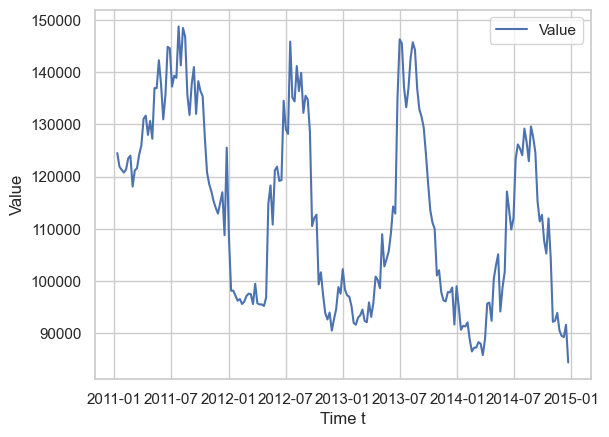

<Figure size 1000x700 with 0 Axes>

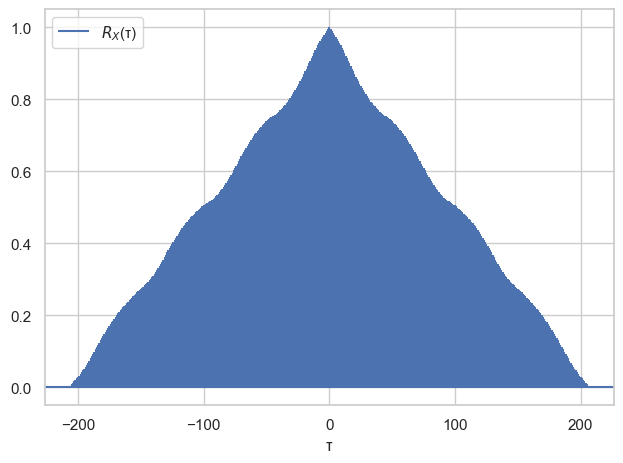

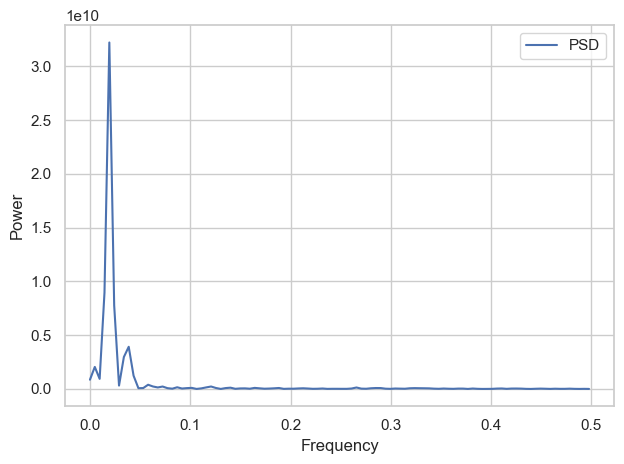

Max Power at period 51.75


In [3]:
ts_plots(weekly_overall, auto_lags = None) # Plot the timeseries, autocorrelation and PSD

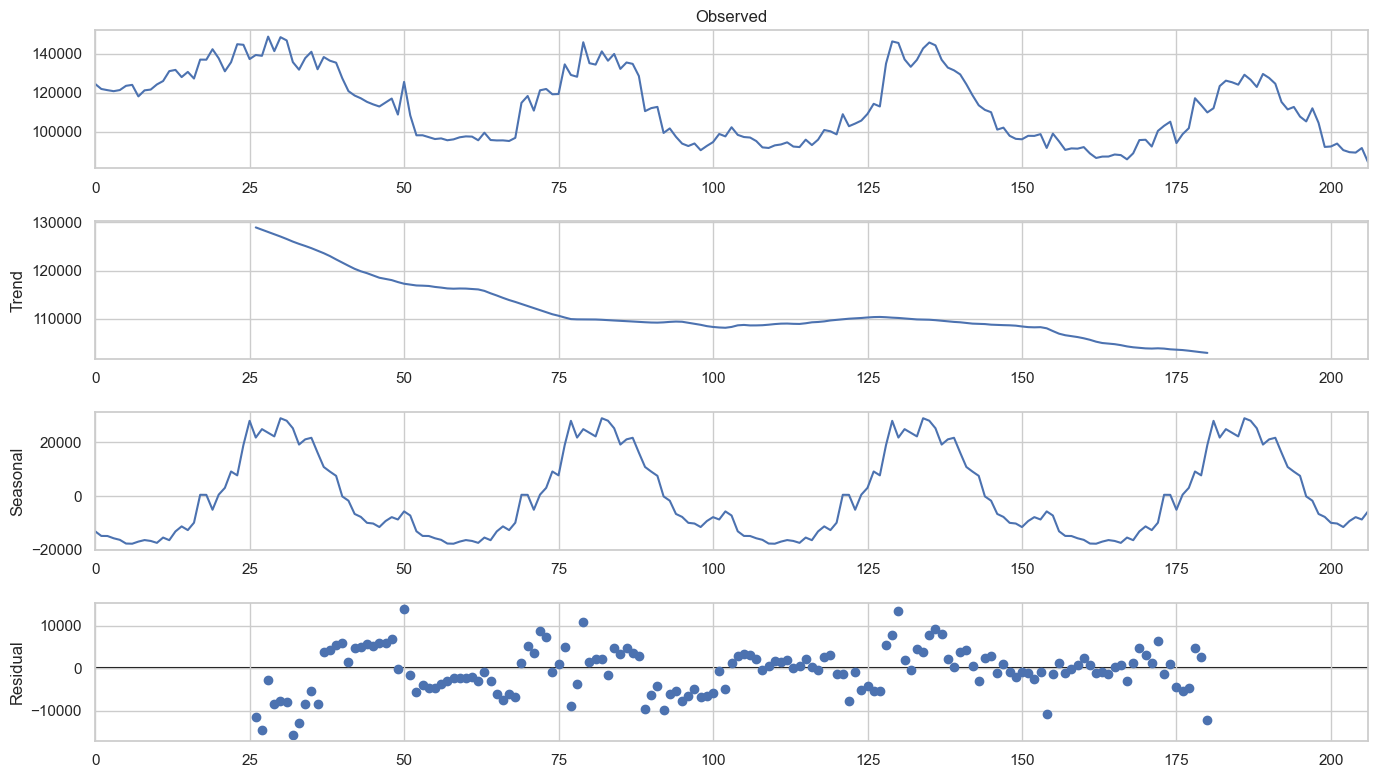

In [4]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=14)
result = seasonal_decompose(weekly_overall.value.values, period = 52, model='additive') # seasonal decomposition of overall ts
fig = result.plot()
# Appears to have 1st order trend with seasonal component, period of 52

In [7]:
train, valid, fit, predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    0, 1, 1, 0, 1, 1, 52,
    type = 'valid')

MAPE = 12.79%


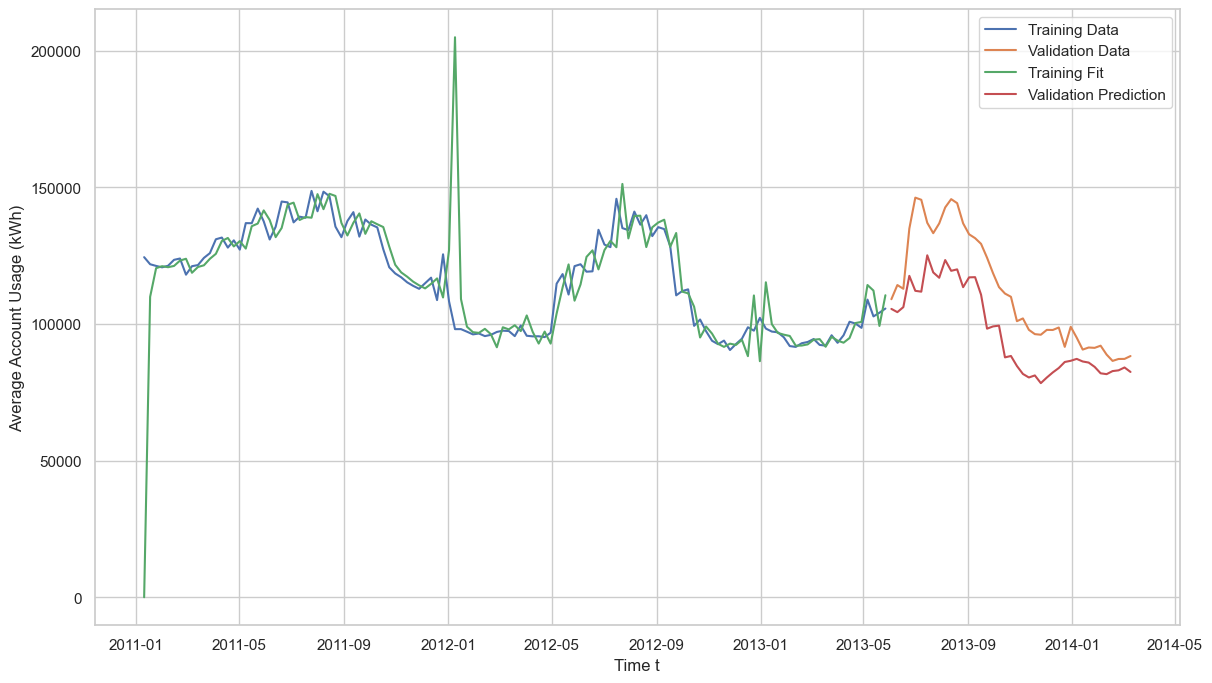

In [8]:
plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [9]:
# Hyperparameter tuning on overall data
best_p, best_d, best_q = np.nan, np.nan, np.nan
best_mape = 1e9
for p in [0, 1, 2]:
    for d in [0, 1, 2]:
        for q in [0, 1, 2]:
            train, valid, fit, predictions = train, test_sets, fit, test_predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
                weekly_overall,
                round(len(weekly_overall)*0.2),
                round(len(weekly_overall)*0.2), 
                p, d, q, p, d, q, 52,
                type = 'valid')
            current_mape =  MAPE(valid.value.values, predictions.values)
            print('p={}, d={}, q={}, MAPE={}'.format(p, d, q, current_mape))
            if current_mape < best_mape:
                best_mape = current_mape
                best_p, best_d, best_q = p, d, q


p=0, d=0, q=0, MAPE=1.0
p=0, d=0, q=1, MAPE=0.6383864520169075
p=0, d=0, q=2, MAPE=0.45895263833514094
p=0, d=1, q=0, MAPE=0.14660872317564813


In [57]:
print("MAPE for the first region = {:0.2%}".format(MAPE(test.value.values[:int(len(test.value.values)/3)],prediction.values[:int(len(prediction.values)/3)])))
print("MAPE for the secont region = {:0.2%}".format(MAPE(test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)],prediction.values[int(len(prediction.values)/3):int(2*len(test.value.values)/3)])))
print("MAPE for the third region = {:0.2%}".format(MAPE(test.value.values[int(2*len(test.value.values)/3):],prediction.values[int(2*len(prediction.values)/3):])))

MAPE for the first region = 4.60%
MAPE for the secont region = 6.72%
MAPE for the third region = 13.10%


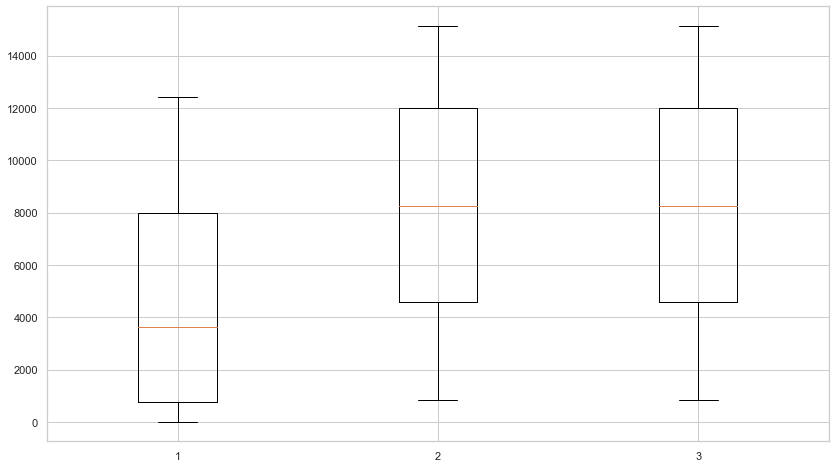

In [67]:
test_first_third = test.value.values[:int(len(test.value.values)/3)]
prediction_first_third = prediction.values[:int(len(prediction.values)/3)]
error_first_third = np.abs(test_first_third-prediction_first_third)

test_second_third = test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
prediction_second_third = prediction.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
error_second_third = np.abs(test_second_third-prediction_second_third)

test_third_third = test.value.values[int(2*len(test.value.values)/3):]
prediction_third_third = prediction.values[int(2*len(prediction.values)/3):]
error_third_third = np.abs(test_third_third-prediction_third_third)


data = [error_first_third,error_second_third,error_second_third]
plt.boxplot(data)
plt.ylabel("Absolute Error")
plt.xlabel("Region")

In [68]:
account_numbers = []
account_train = []
account_valid = []
account_test = []
account_fit = []
account_valid_fit = []
account_prediction = []
account_mape = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])
        train, valid, test, fit, valid_fit, prediction = walk_forward_validation_sarimax(df_account, round(len(df_account)*0.80), round(len(df_account)*0.6), 0, 1, 1, 0, 1, 1, 52)
        account_numbers.append(account_number)
        account_train.append(train)
        account_valid.append(valid)
        account_test.append(test)
        account_fit.append(fit)
        account_valid_fit.append(valid_fit)
        account_prediction.append(prediction)
        account_mape.append(MAPE(test.value.values, prediction.values))
    except:
        account_errors.append(account_number)
        continue

100%|███████████████████████████████████████| 370/370 [1:10:07<00:00, 11.37s/it]


Text(0, 0.5, 'Number of Accounts')

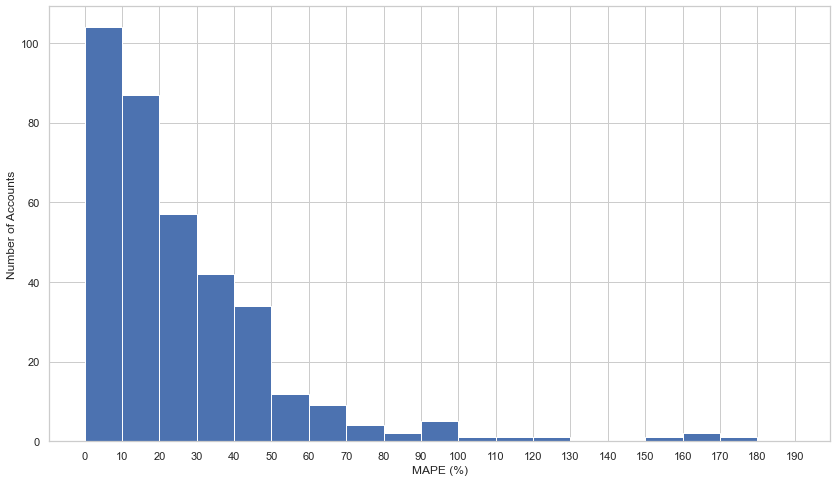

In [69]:
plt.hist(np.array(account_mape)*100, bins = np.arange(0, 200, 10))
plt.xticks(np.arange(0, 200, 10))
plt.xlabel('MAPE (%)')
plt.ylabel('Number of Accounts')

MAPE = 9.10%


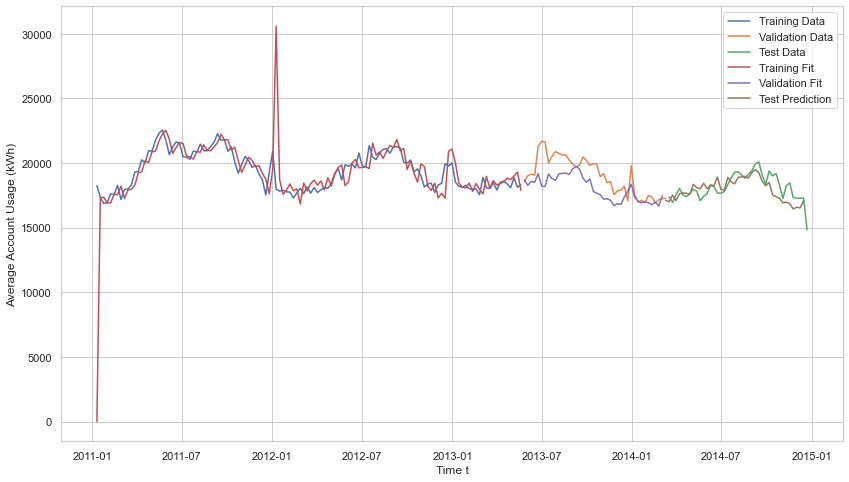

In [70]:
index = account_mape.index(min(account_mape))
plt.plot(account_train[index], label = 'Training Data')
plt.plot(account_valid[index], label = 'Validation Data')
plt.plot(account_test[index], label = 'Test Data')
plt.plot(account_fit[index], label = 'Training Fit')
plt.plot(account_valid_fit[index], label = 'Validation Fit')
plt.plot(account_prediction[index], label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(test.value.values, prediction.values)))

In [71]:
# Total MAPE
mapes  = []
for i in np.arange(len(account_mape)):
    actual = account_test[i].value.values
    pred = account_prediction[i].values
    mapes = mapes + (np.abs((actual - pred))/(actual)).tolist()
print('Total MAPE is {:.1%}'.format(np.mean(mapes)))
print('Median MAPE is {:.1%}'.format(np.median(mapes)))

Total MAPE is 30.7%
Median MAPE is 15.9%


In [82]:
## FB Prophet ##
model = Prophet()
prophet_train = train_valid_test_split(weekly_overall, round(len(weekly_overall)*0.80), round(0.6*len(weekly_overall)))[0]
prophet_valid = train_valid_test_split(weekly_overall, round(len(weekly_overall)*0.80), round(0.6*len(weekly_overall)))[1]
prophet_test = train_valid_test_split(weekly_overall, round(len(weekly_overall)*0.80), round(0.6*len(weekly_overall)))[2]

prophet_train['ds'] = prophet_train.index.values
prophet_train.rename(columns = {'value': 'y'}, inplace = True)
prophet_valid['ds'] = prophet_valid.index.values
prophet_valid.rename(columns = {'value': 'y'}, inplace = True)
prophet_test['ds'] = prophet_test.index.values
prophet_test.rename(columns = {'value': 'y'}, inplace = True)

In [83]:
model.fit(prophet_train)

19:48:35 - cmdstanpy - INFO - Chain [1] start processing
19:48:35 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
train = prophet_train
valid = prophet_valid
test = prophet_test

fit = model.predict(pd.DataFrame({'ds': prophet_train['ds']}))[['ds', 'yhat']].set_index('ds')
valid_fit = model.predict(pd.DataFrame({'ds': prophet_valid['ds']}))[['ds', 'yhat']].set_index('ds')
prediction = model.predict(pd.DataFrame({'ds': prophet_test['ds']}))[['ds', 'yhat']].set_index('ds')

MAPE = 14.85%


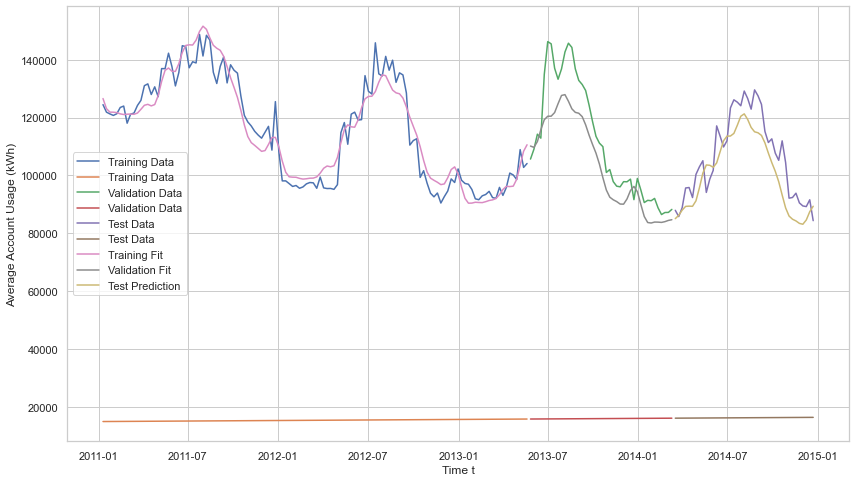

In [128]:
plt.plot(train, label = 'Training Data')
plt.plot(valid, label = 'Validation Data')
plt.plot(test, label = 'Test Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(valid_fit, label = 'Validation Fit')
plt.plot(prediction, label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE([item[0] for item in test.values], prediction.values)))

In [129]:
a = [item[0] for item in test.values]
print("MAPE for the first region = {:0.2%}".format(MAPE(a[:int(len(a)/3)],prediction.values[:int(len(prediction.values)/3)])))
print("MAPE for the secont region = {:0.2%}".format(MAPE(a[int(len(a)/3):int(2*len(a)/3)],prediction.values[int(len(prediction.values)/3):int(2*len(prediction.values)/3)])))
print("MAPE for the third region = {:0.2%}".format(MAPE(a[int(2*len(a)/3):],prediction.values[int(2*len(prediction.values)/3):])))

MAPE for the first region = 8.92%
MAPE for the secont region = 7.05%
MAPE for the third region = 11.43%


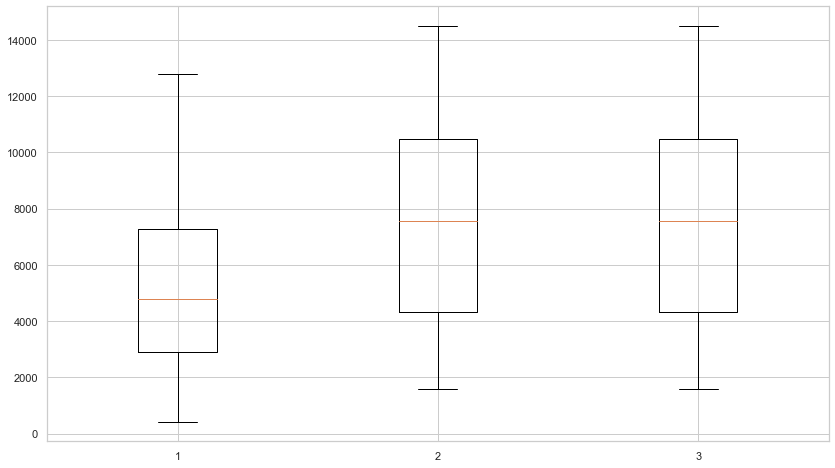

In [137]:
prediction = [item for item in prediction['yhat']]

test_first_third = a[:int(len(a)/3)]
prediction_first_third = prediction[:int(len(prediction)/3)]
error_first_third = np.abs(np.array(test_first_third)-np.array(prediction_first_third))

test_second_third = a[int(len(a)/3):int(2*len(a)/3)]
prediction_second_third = prediction[int(len(prediction)/3):int(2*len(prediction)/3)]
error_second_third = np.abs(np.array(test_second_third)-np.array(prediction_second_third))

test_third_third = a[int(2*len(a)/3):]
prediction_third_third = prediction[int(2*len(prediction)/3):]
error_third_third = np.abs(np.array(test_third_third)-np.array(prediction_third_third))


data = [error_first_third,error_second_third,error_second_third]
plt.boxplot(data);


In [154]:
from statsmodels.tsa.arima.model import ARIMA

def walk_forward_validation_arima(df, n_test, n_validation, p, d, q):
    """
    Perform walk-forward validation with a defined n_test in the data

    Parameters
    ----------
    df (pd.DataFrame) - input timeseries DataFrame
    n_test (int) - number of test points
    p, d, q, s_p, s_d, s_q, seasonality (int) - SARIMAX parameters
    """
    train, valid, test = train_valid_test_split(df, n_test, n_validation)
    model = ARIMA(
        train,
        order = (p, d, q)
    )
    model_fit = model.fit()
 
    # walk forward
    predictions1 = model_fit.forecast(len(test)*2)
    predictions = predictions1[int(len(predictions1)/2):]
    valid_fit = predictions1[:int(len(predictions1)/2)]
    # estimate error
    return train, valid, test, model_fit.predict(), valid_fit, predictions



In [155]:
train, valid, test, fit, valid_fit, prediction = walk_forward_validation_arima(weekly_overall, round(len(weekly_overall)*0.80), round(len(weekly_overall)*0.6), 0, 1, 1)

MAPE = 11.53%


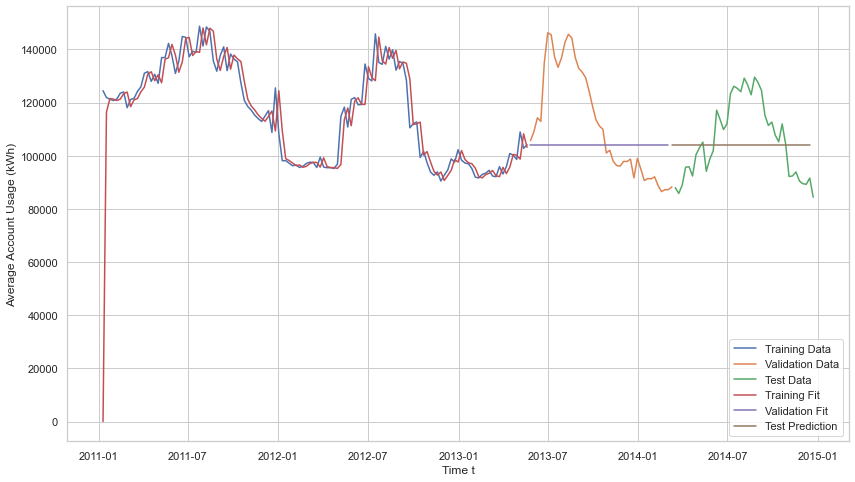

In [156]:
plt.plot(train, label = 'Training Data')
plt.plot(valid, label = 'Validation Data')
plt.plot(test, label = 'Test Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(valid_fit, label = 'Validation Fit')
plt.plot(prediction, label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(test.value.values, prediction.values)))

In [157]:
print("MAPE for the first region = {:0.2%}".format(MAPE(test.value.values[:int(len(test.value.values)/3)],prediction.values[:int(len(prediction.values)/3)])))
print("MAPE for the secont region = {:0.2%}".format(MAPE(test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)],prediction.values[int(len(prediction.values)/3):int(2*len(test.value.values)/3)])))
print("MAPE for the third region = {:0.2%}".format(MAPE(test.value.values[int(2*len(test.value.values)/3):],prediction.values[int(2*len(prediction.values)/3):])))

MAPE for the first region = 9.37%
MAPE for the secont region = 14.55%
MAPE for the third region = 10.53%


Text(0.5, 0, 'Region')

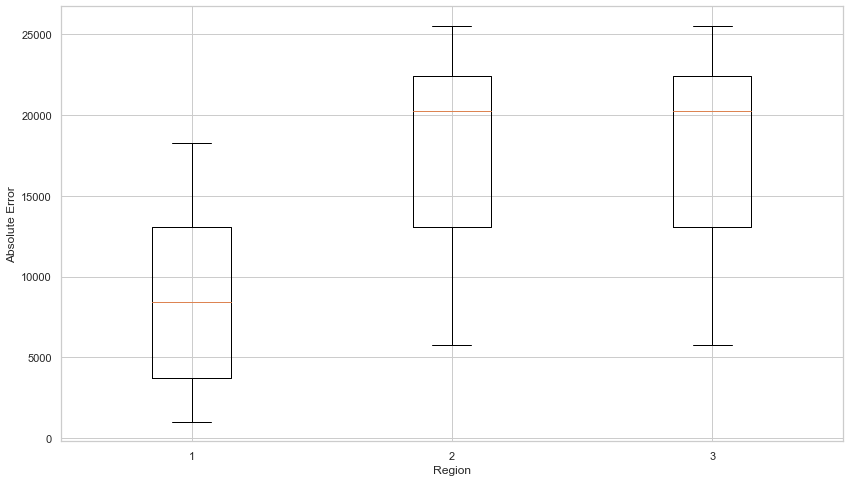

In [158]:
test_first_third = test.value.values[:int(len(test.value.values)/3)]
prediction_first_third = prediction.values[:int(len(prediction.values)/3)]
error_first_third = np.abs(test_first_third-prediction_first_third)

test_second_third = test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
prediction_second_third = prediction.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
error_second_third = np.abs(test_second_third-prediction_second_third)

test_third_third = test.value.values[int(2*len(test.value.values)/3):]
prediction_third_third = prediction.values[int(2*len(prediction.values)/3):]
error_third_third = np.abs(test_third_third-prediction_third_third)


data = [error_first_third,error_second_third,error_second_third]
plt.boxplot(data)
plt.ylabel("Absolute Error")
plt.xlabel("Region")